In [5]:
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = 0 if torch.cuda.is_available() else -1

checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint).to(device)




In [11]:
import os
from PIL import Image
import numpy as np
import cv2

input_dir = "val_selection_cropped/test_images_dontuse"  # Replace with your input directory
output_dir = "val_selection_cropped/test_depth_estimates_dontsave"  # Replace with your output directory

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(input_dir, filename)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        w, h = image.size  # PIL gives (width, height)

        inputs = processor(images=image, return_tensors="pt").to(device)

        # Perform depth estimation
        with torch.no_grad():
            outputs = model(**inputs) # 

        post_processed = processor.post_process_depth_estimation(outputs,
                                                                 target_sizes=[(h, w)],  # ensure SAME resolution as RGB
                                                                 )
        predicted_depth = post_processed[0]["predicted_depth"]  # (H, W), float32-ish

        # move to cpu + numpy
        depth_np = predicted_depth.detach().cpu().numpy().astype("float32")
        
        # per-image normalization to [0,1] for stability -- These are NOT true depths, only structure
        d_min, d_max = depth_np.min(), depth_np.max()
        depth_np = (depth_np - d_min) / (d_max - d_min + 1e-8)
        print(depth_np)
        
        # Construct output path and save
        output_filename = os.path.splitext(filename)[0] + "_depth_estimate.npy"
        output_path = os.path.join(output_dir, output_filename)
        np.save(output_path, depth_np)

        print(f"Processed {filename} and saved depth map to {output_path}")

[[0.03705769 0.03705769 0.03705769 ... 0.37289307 0.3738401  0.34789085]
 [0.03705769 0.03705769 0.03705769 ... 0.3736009  0.3718931  0.3728388 ]
 [0.03705769 0.03705769 0.03705769 ... 0.37300223 0.3727417  0.37171575]
 ...
 [0.94134456 0.94124705 0.941298   ... 0.956159   0.9546872  0.9531424 ]
 [0.94582736 0.9454603  0.9457706  ... 0.9573648  0.9584937  0.9572368 ]
 [0.95183784 0.9489761  0.9507985  ... 0.9637961  0.9611873  0.9636227 ]]
Processed 2011_09_26_drive_0002_sync_image_0000000005_image_02.png and saved depth map to val_selection_cropped/test_depth_estimates_dontsave\2011_09_26_drive_0002_sync_image_0000000005_image_02_depth_estimate.npy
[[0.16633014 0.16283083 0.16515808 ... 0.21263921 0.21035601 0.2000981 ]
 [0.16420071 0.16533981 0.16394137 ... 0.21236688 0.21228176 0.21415375]
 [0.16367616 0.16297132 0.1623709  ... 0.21209434 0.21264262 0.21332207]
 ...
 [0.9478106  0.9474166  0.94728565 ... 0.90529877 0.90512806 0.90370935]
 [0.9507     0.95110625 0.951986   ... 0.9029

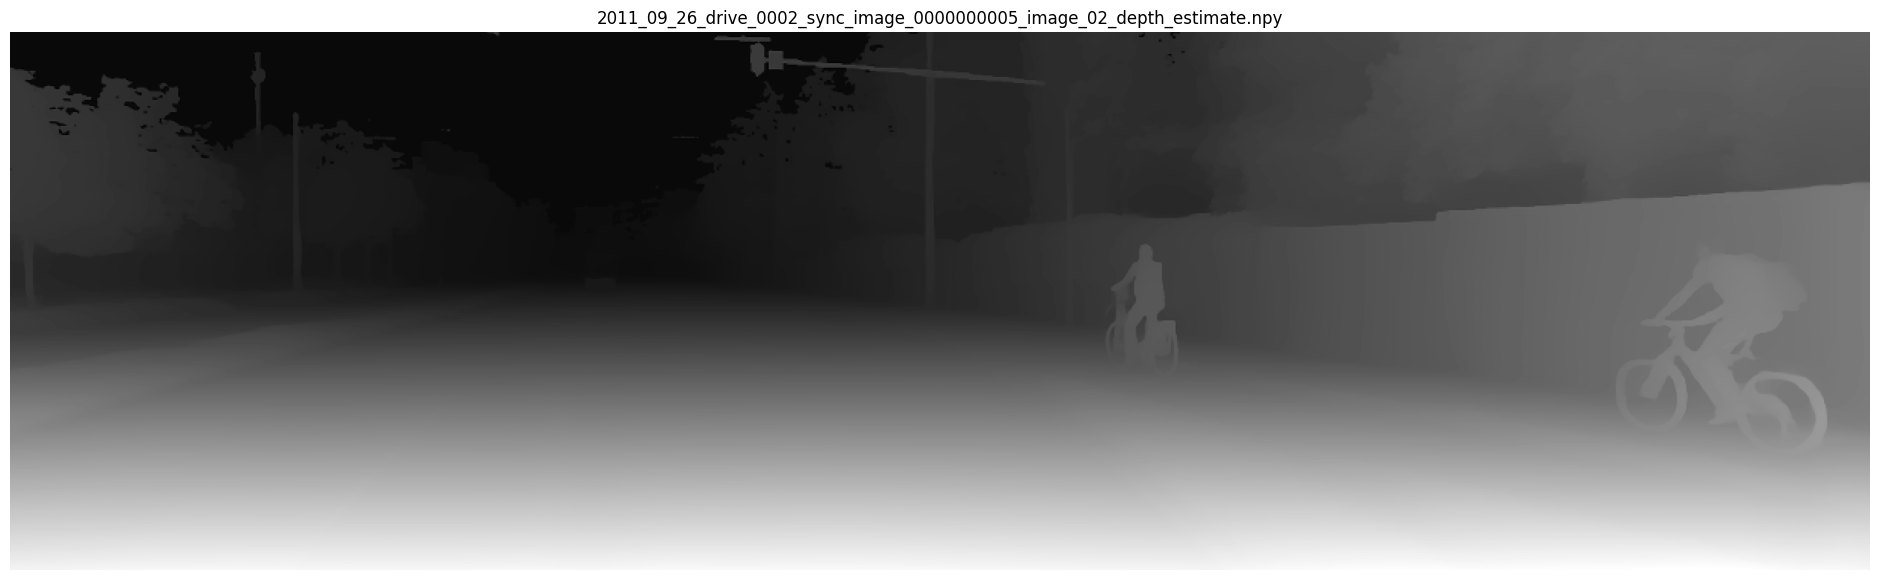

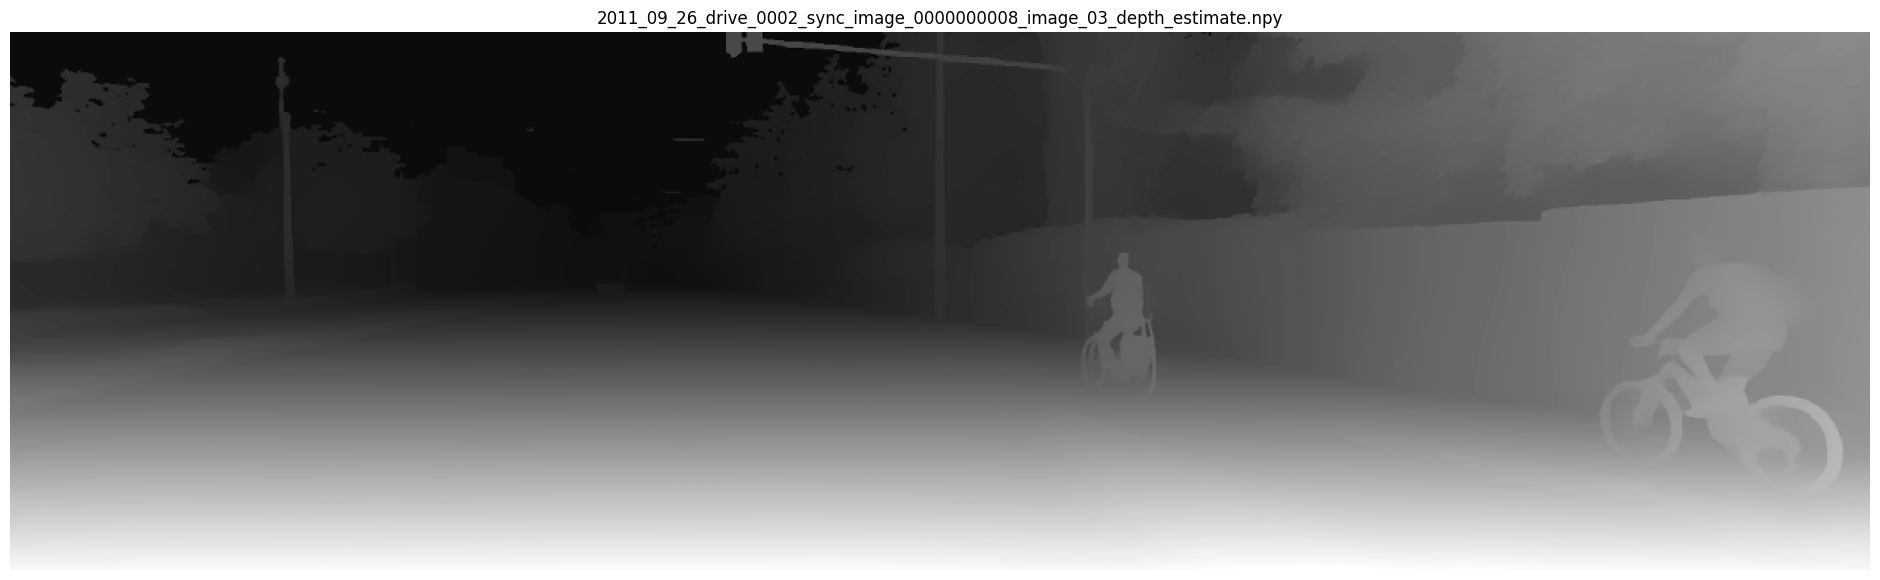

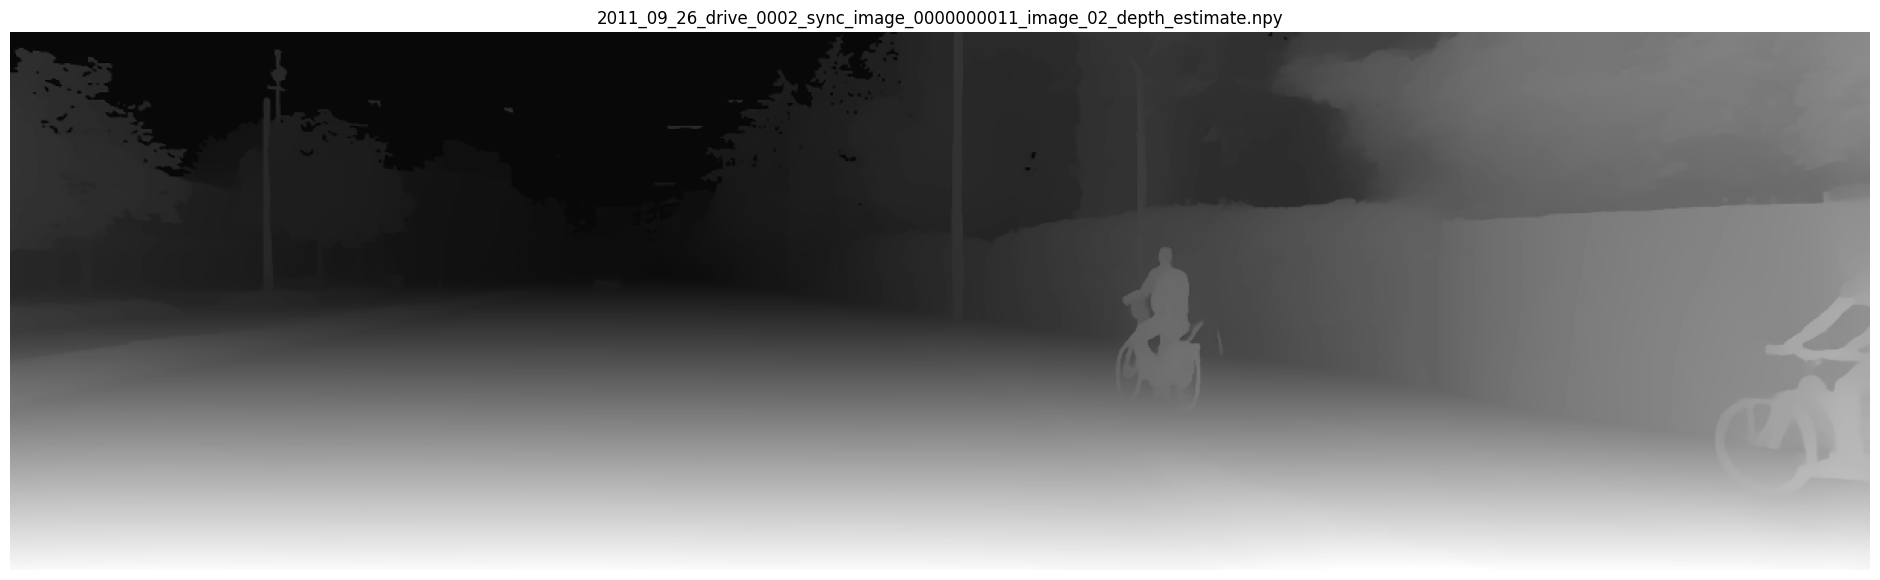

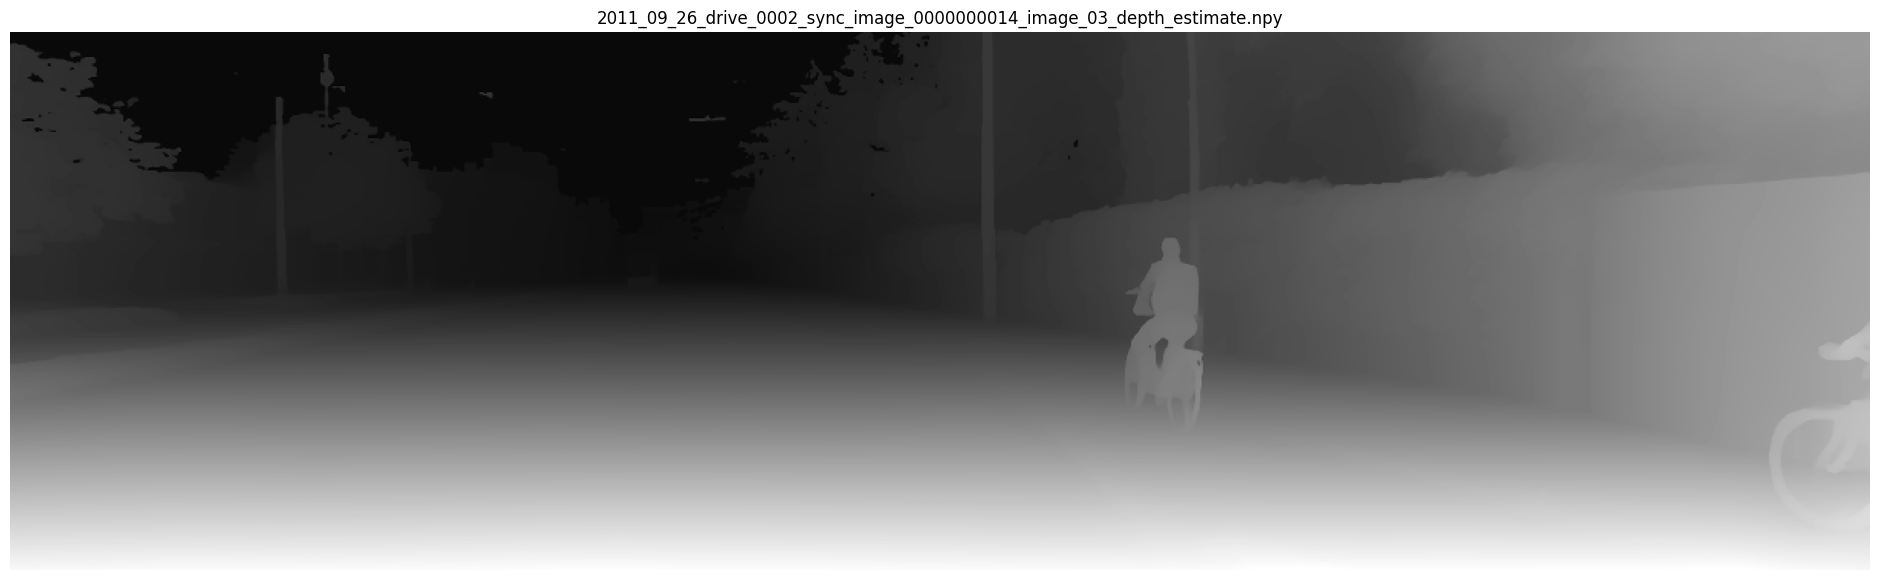

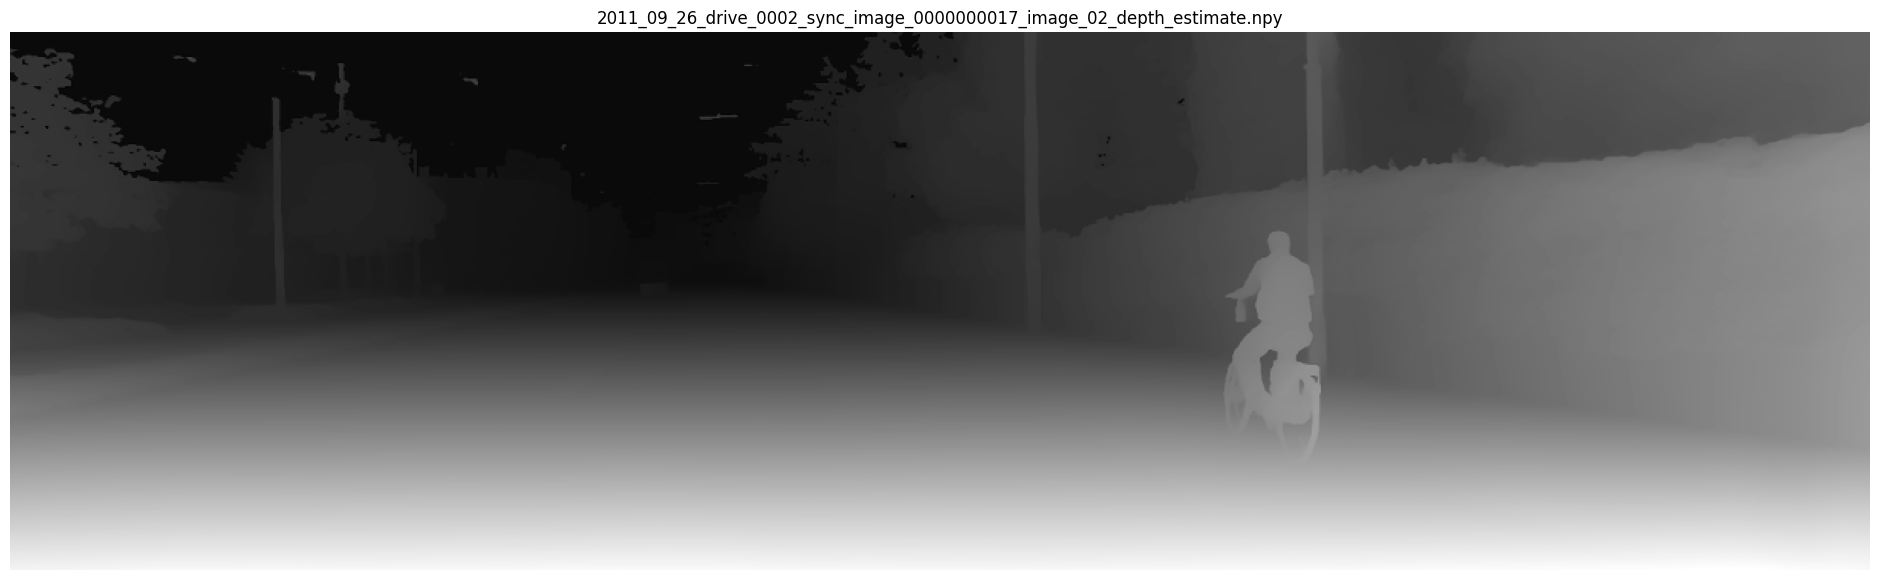

In [5]:
# Visualize .npy files in full resolution grayscale from dir: val_selection_cropped/depth_estimates

import matplotlib.pyplot as plt
import os
import numpy as np

depth_estimates_dir = "val_selection_cropped/depth_estimates"



for i, filename in enumerate(os.listdir(depth_estimates_dir)):
    if filename.endswith(".npy"):
        depth_map = np.load(os.path.join(depth_estimates_dir, filename))
        plt.figure(figsize=(24, 18))
        plt.imshow(depth_map, cmap='gray')
        plt.title(filename)
        plt.axis('off')
        plt.show()

    if i>3:
        break
    





